In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
#Understand the structure of measurement data set 
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Understand the structure of station data set 
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [13]:
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [14]:
# Perform a query to retrieve the data and precipitation scores
query = session.query(measurement.date, measurement.prcp).filter(measurement.date >= year_ago).all()
query
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date
df = pd.DataFrame(query, columns = ['date', 'prcp'])
df = df.sort_values('date')
df = df.dropna()

df = df.rename(columns={"date": "Date", "prcp": "Precipitation"})
df

,Date,Precipitation
0,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
1881,2016-08-23,0.70
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


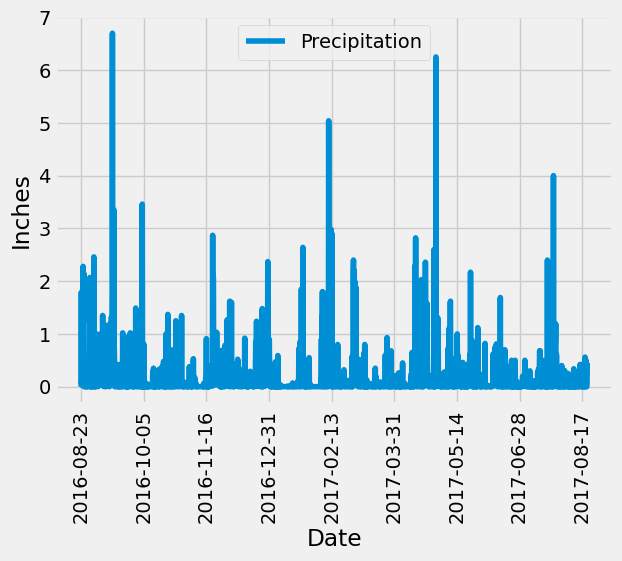

In [15]:
#Plot data
df.plot(x='Date', y='Precipitation')

#Label graph
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(['Precipitation'], loc = 'upper center')
plt.xticks(rotation=90)
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_df = pd.DataFrame(df['Precipitation'].describe())
summary_df

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
count = session.query(station.station).count()
print(f'There are {count} stations in the dataset')

There are 9 stations in the dataset


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(measurement.station, func.count(measurement.station))

grouped = station_counts.group_by(measurement.station)

ordered = grouped.order_by(func.count(measurement.station).desc()).all()
for station in ordered:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [36]:
# Using the most active station id from the previous query, 
#calculate the lowest, highest, and average temperature.
most_active = ordered[0][0]
temp_low = session.query(func.min(measurement.tobs)).filter(measurement.station == most_active).all()
temp_high = session.query(func.max(measurement.tobs)).filter(measurement.station == most_active).all()
temp_avg = session.query(func.avg(measurement.tobs)).filter(measurement.station == most_active).all()
print(f'Lowest temp: {temp_low}')
print(f'Highest temp: {temp_high}')
print(f'Average temp: {temp_avg}')

Lowest temp: [(54.0,)]
Highest temp: [(85.0,)]
Average temp: [(71.66378066378067,)]


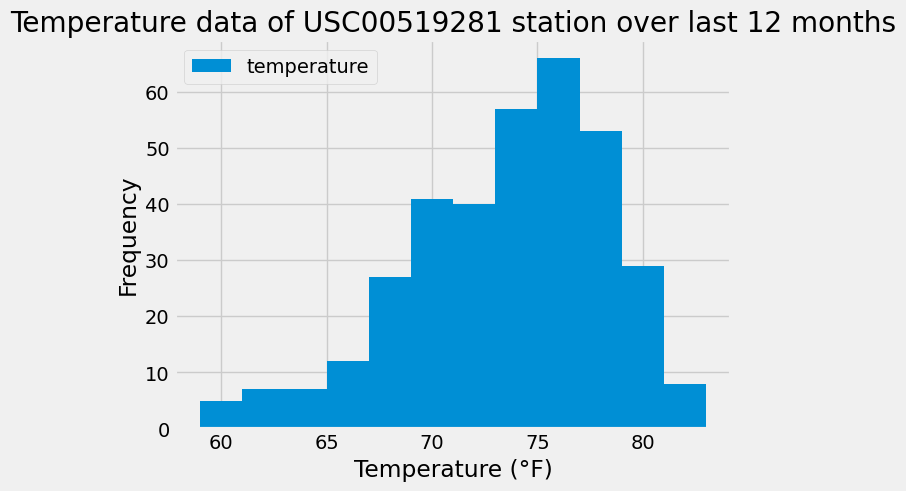

In [45]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(measurement.tobs).filter(measurement.station == most_active).filter(measurement.date >= year_ago).all()
temps = [temp[0] for temp in query]
plt.hist(temps, bins = 12, label = 'temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature data of {most_active} station over last 12 months')
plt.legend()
plt.show()

# Close Session

In [44]:
# Close Session
session.close()